In [1]:
%pylab inline
from qutip import *
import numpy as np


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:

total_time = 200
steps = 1000
time_list = np.linspace(0,total_time, steps)
mode_state_num = 35
qubit_state_num = 2
RWA = True
RFT = True

#Blais parameters:
kappa = 1.0/160
gamma = 0.001
fc = 10
fa = 9
g = 0.1*np.pi

kappa = 0.05
gamma = 0.001
g = 0.05
fc = 5/(2*np.pi)
fa = 4.6/(2*np.pi)

a = tensor(destroy(mode_state_num), qeye(qubit_state_num))
sm = tensor(qeye(mode_state_num), destroy(qubit_state_num))
wc = 2*np.pi*fc
wa = 2*np.pi*fa
if RWA:
    H0 = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a *sm.dag())
else:
    H0 = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())

        
en,es=H0.eigenstates()
g0 = es[0]
e0 = es[1]

if RFT:
    
    H0 = (wa -wc) * sm.dag() *sm + g * (a.dag() * sm + a *sm.dag())
   
    

c_ops = []
c_ops.append(np.sqrt(kappa)*a)
c_ops.append(np.sqrt(gamma)*sm)

HI = a + a.dag()
HQ = (0+1j)* (a-a.dag())
            


In [ ]:
chi = g*g/(wc - wa)
print chi
print chi/kappa

In [7]:
args ={}
args['wc'] = wc
if RFT:
    Isignal = "0.05*tanh(t/10.)"
else:
    Isignal = "0.001*tanh(t/10.)*cos(wc*t)"

H = [H0, [HI, Isignal]]
#g_output = mcsolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=10000, options=Options(nsteps=15), args = args)

#e_output = mcsolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=10000, options=Options(nsteps=15), args= args)
g_output = mesolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], options=Options(nsteps=15), args = args)
e_output = mesolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], options=Options(nsteps=15), args= args)



In [6]:

gIs = []
eIs = []
for ii in range (1):
    g_output = mcsolve(H, g0, time_list, c_ops, [ HI], ntraj=1, options=Options(nsteps=10), args = args, progress_bar = False)
    e_output = mcsolve(H, e0, time_list, c_ops, [ HI], ntraj=1, options=Options(nsteps=10), args = args, progress_bar = False)
    gIs.append(g_output.expect[0])
    eIs.append(e_output.expect[0])
    sys.stdout.write('\r'+str(ii))
    sys.stdout.flush()
    

0

In [ ]:
print (np.shape(eIs))

In [ ]:
np.save("/home/mohamed/Data/gtrajs2", gIs)
np.save("/home/mohamed/Data/etrajs2", eIs)

In [ ]:
def Rotate (I, Q, theta):
    return I *cos (theta) + Q* sin (theta), -I* sin (theta) + Q *cos (theta)


In [4]:
def AWGN(time_list, nbar, n_to_power):
    noise  = numpy.random.normal(size= np.shape(time_list))
    amp = nbar * n_to_power
    noise = np.sqrt(amp) *noise
    return noise

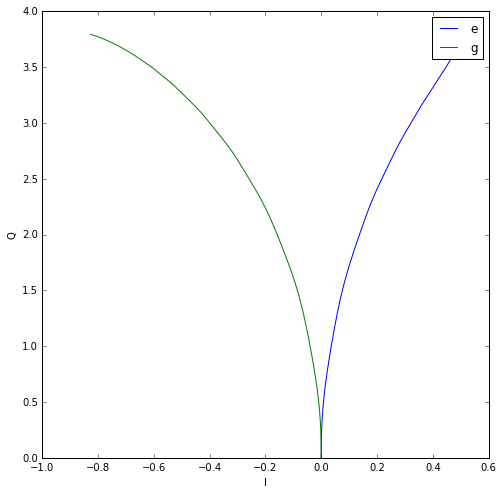

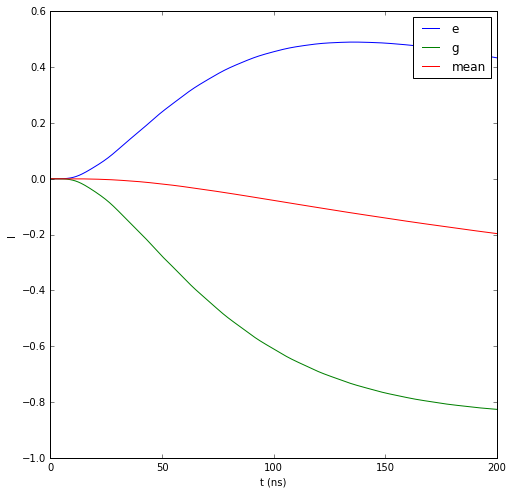

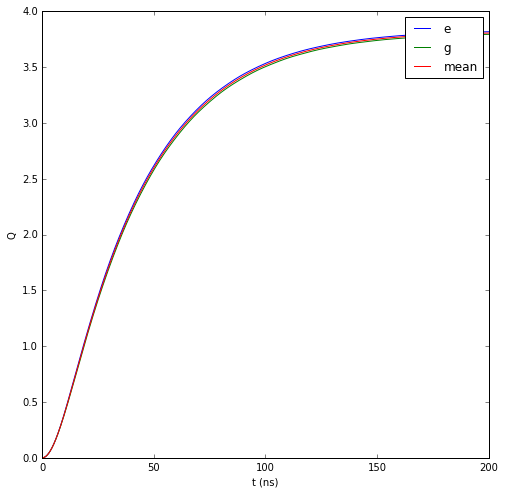

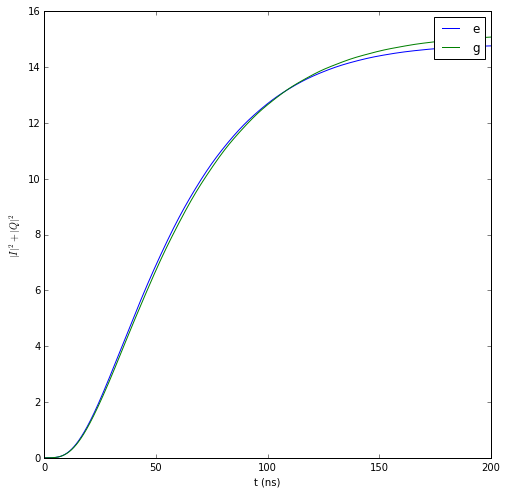

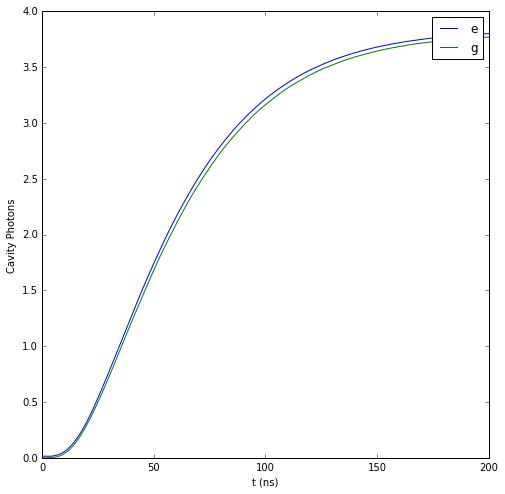

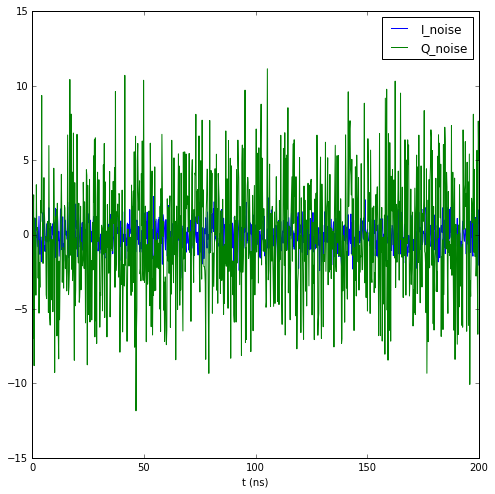

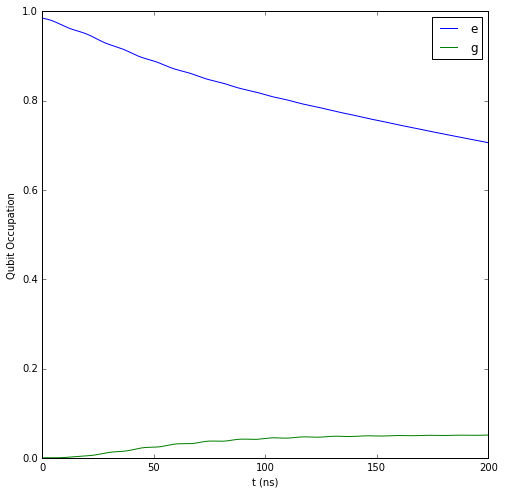

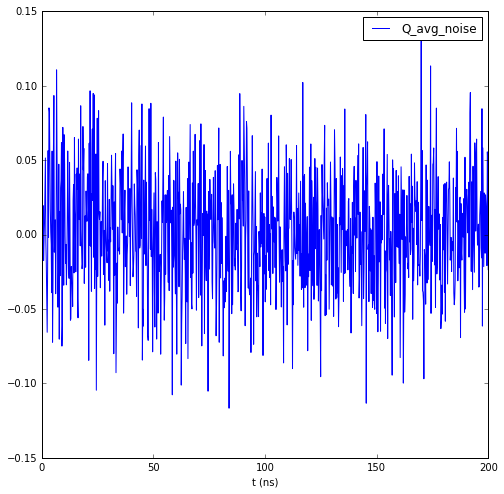

In [8]:
Ie = e_output.expect[0]
Ig = g_output.expect[0]
Qe = e_output.expect[1]
Qg = g_output.expect[1]




if not RFT:
    Ie, Qe = Rotate (Ie, Qe, wc*time_list)
    Ig, Qg = Rotate (Ig, Qg, wc*time_list)

Imid = 0.5*(Ie + Ig)
Qmid = 0.5*(Qe + Qg)
Idiff = np.abs(Ie-Ig)
Qdiff = np.abs(Qe - Qg)
figsize(8,8)

figure()
plot (Ie,Qe, label ="e")
plot (Ig,Qg, label = "g")
ylabel ("Q")
xlabel("I")
legend()

figure()
plot (time_list,Ie, label="e")
plot (time_list,Ig, label = "g")
plot (time_list, Imid, label = "mean")
xlabel('t (ns)')
ylabel('I')
legend()

figure()
plot (time_list,Qe, label= "e")
plot (time_list,Qg, label = "g")
plot (time_list, Qmid, label = "mean")
xlabel('t (ns)')
ylabel('Q')
legend()

figure()
plot (time_list,np.square(np.abs(Qe)) + np.square(np.abs(Ie)), label = "e")
plot (time_list,np.square(np.abs(Qg)) + np.square(np.abs(Ig)), label ="g")
xlabel('t (ns)')
ylabel('$|I|^2 + |Q|^2$')
legend()

figure()
plot ( time_list, e_output.expect[2], label ="e")
plot ( time_list, g_output.expect[2], label = "g")
xlabel('t (ns)')
legend()


avgd_noise_num = 10000
x = np.zeros(len(time_list))
for ii in range (avgd_noise_num):
    x = x +AWGN(time_list, 4, 3.75)
x = x/avgd_noise_num
ylabel('Cavity Photons')
figure()
plot ( time_list, AWGN(time_list, 4, 0.225), label ="I_noise")
plot ( time_list, AWGN(time_list, 4, 3.75), label ="Q_noise")
xlabel('t (ns)')
legend()
figure()
plot (time_list, e_output.expect[3], label = "e")
plot ( time_list, g_output.expect[3], label = "g")

xlabel('t (ns)')
legend()
ylabel('Qubit Occupation')

figure()
plot ( time_list, x, label ="Q_avg_noise")
xlabel('t (ns)')
legend()


In [ ]:
expecte = np.load("e_1000_traj.npy")
expectg = np.load("g_1000_traj.npy")
Ie = expecte[0]
Qe = expecte[1]
Ig = expectg[0]
Qg = expectg[1]
Imid = 0.5*(Ie + Ig)
Qmid = 0.5*(Qe + Qg)
Idiff = np.abs(Ie-Ig)
Qdiff = np.abs(Qe - Qg)

In [ ]:
args ={}
args['wc'] = wc
if RFT:
    Isignal = "0.01*tanh(t/10.)"
else:
    Isignal = "0.01*tanh(t/10.)*cos(wc*t)"
H = [H0, [HI, Isignal]]
errors = 0
for ii in range (50):
    g_test_output = mcsolve(H, g0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=1, options=Options(nsteps=15), args = args, progress_bar = False)
    Ig_test = g_test_output.expect[0]
    Qg_test = g_test_output.expect[1]
    
    if not RFT:
        Ig_test, Qg_test = Rotate (Ig_test, Qg_test, wc*time_list)
    
    decision = np.sum((Ig_test - Imid)*Idiff) + np.sum((Qg_test - Qmid)*Qdiff)
    if decision > 0:
        errors +=1
print (errors)
            
    
    
    

In [ ]:
args ={}
args['wc'] = wc
if RFT:
    Isignal = "0.01*tanh(t/10.)"
else:
    Isignal = "0.01*tanh(t/10.)*cos(wc*t)"
H = [H0, [HI, Isignal]]
errors = 0
#exps = np.exp(-time_list)
len_tfinal = steps/10
for ii in range (100):
    e_test_output = mcsolve(H, e0, time_list, c_ops, [ HI, HQ, a.dag()*a, sm.dag()*sm], ntraj=1, options=Options(nsteps=15), args = args, progress_bar = False)
    Ie_test = e_test_output.expect[0]
    Qe_test = e_test_output.expect[1]
    
    if not RFT:
        Ie_test, Qe_test = Rotate (Ie_test, Qe_test, wc*time_list)
    
    #decision = np.sum((Ie_test[0:len_tfinal] - Imid[0:len_tfinal])) + np.sum((Qe_test[0:len_tfinal] - Qmid[0:len_tfinal]))
    decision = np.sum((Ie_test[0:len_tfinal] - Imid[0:len_tfinal])*Idiff[0:len_tfinal]) + np.sum((Qe_test[0:len_tfinal] - Qmid[0:len_tfinal])*Qdiff[0:len_tfinal])
    #decision = np.sum((Ie_test - Imid)*exps*Idiff) + np.sum((Qe_test - Qmid)*Qdiff*exps)
    if decision < 0:
        errors +=1
        figure()
        plot (time_list,Ie_test, label ="test")
        plot (time_list,Ig, label = "g")
        plot (time_list,Ie, label = "e")

        plot (time_list,Imid, label = "mean")

        ylabel ("I")
        xlabel("t")
        legend()

print (errors)
            
    
    
    